# Static GCN Baseline

**Objective**: 2-layer GCN using graph structure and node features.

**Key principle**: Each node v evaluated at exactly t_first(v) + K.

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm.notebook import tqdm

torch.manual_seed(42)
np.random.seed(42)

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG.copy()
# GCN-specific hyperparameters
CONFIG['dropout'] = 0.5
CONFIG['learning_rate'] = 0.01
CONFIG['weight_decay'] = 5e-4
CONFIG['epochs'] = 200
CONFIG['patience'] = 20

print(f"Device: {CONFIG['device']}")

Device: cuda


## Load Data & Create Splits

In [3]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache',
    use_cache=True,
    verbose=True
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"Train: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (116): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_median_fees', 'in_total_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False

Temporal Split Summary:
  Train: timesteps 5-24, 96470 nodes
    Illicit: 4888, Licit: 91582
Training illicit ratio: 0.050668601637814864
  Val:   timesteps 29-31, 9884 nodes
    Illicit: 664, Licit: 9220
Validation illicit ratio: 0.06717927964386888
  Test:  timesteps 37-43, 39305 nodes
    Illicit: 1849, Licit: 37456
Test illicit ratio: 0.04704236102277064
Train: 96470 nodes
Val:   9884 nodes
Test:  39305 nodes


## Prepare Per-Node Graphs

Each node evaluated at t_first(v) + K.

In [4]:
device = torch.device(CONFIG['device'])

graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=device
)


PREPARING OBSERVATION WINDOW GRAPHS (PER-NODE EVALUATION)

K = 0 (Each node evaluated at t_first + 0)

TRAIN split:
  Nodes to evaluate: 96,470
  Evaluation times: t=5 to t=24
  Unique graphs needed: 20
  ✅ Loaded cached graph from ../../graph_cache/graph_t5_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t8_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t9_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t10_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t11_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache/graph_t12_metaTrue_classFalse_tempTrue_w

## GCN Model

In [5]:
class StaticGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## Training Functions

In [6]:
def train_epoch(model, graphs_dict, optimizer, criterion):
    """Train on all graphs in split."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for eval_t, graph in graphs_dict.items():
        optimizer.zero_grad()
        logits = model(graph.x, graph.edge_index)
        
        # Loss only on masked nodes
        loss = criterion(logits[graph.eval_mask], graph.y[graph.eval_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * graph.eval_mask.sum().item()
        pred = logits[graph.eval_mask].argmax(dim=1)
        total_correct += (pred == graph.y[graph.eval_mask]).sum().item()
        total_samples += graph.eval_mask.sum().item()
    
    return total_loss / total_samples, total_correct / total_samples


def evaluate(model, graphs_dict):
    """Evaluate on all graphs in split."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for eval_t, graph in graphs_dict.items():
            logits = model(graph.x, graph.edge_index)
            pred = logits[graph.eval_mask].argmax(dim=1).cpu().numpy()
            true = graph.y[graph.eval_mask].cpu().numpy()
            probs = F.softmax(logits[graph.eval_mask], dim=1)[:, 1].cpu().numpy()
            
            all_preds.append(pred)
            all_labels.append(true)
            all_probs.append(probs)
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Models (Per-K Retraining)

Separate model for each K value.

In [7]:
results = {}
models = {}

for K in CONFIG['observation_windows']:
    print(f"\n{'='*70}")
    print(f"Training with K={K}")
    print('='*70)
    
    train_graphs = graphs[K]['train']['graphs']
    val_graphs = graphs[K]['val']['graphs']
    test_graphs = graphs[K]['test']['graphs']
    
    # Initialize model
    num_features = list(train_graphs.values())[0].x.shape[1]
    model = StaticGCN(
        num_features=num_features,
        hidden_dim=CONFIG['hidden_dim'],
        num_classes=2,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Compute class weights from all training graphs
    all_train_labels = []
    for g in train_graphs.values():
        all_train_labels.append(g.y[g.eval_mask].cpu())
    all_train_labels = torch.cat(all_train_labels).long()
    
    class_counts = torch.bincount(all_train_labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Training loop
    best_val_f1 = 0
    patience_counter = 0
    best_model_state = None
    
    pbar = tqdm(range(CONFIG['epochs']), desc=f"K={K}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_graphs, optimizer, criterion)
        
        if (epoch + 1) % 5 == 0:
            val_metrics = evaluate(model, val_graphs)
            pbar.set_postfix({'loss': f"{train_loss:.4f}", 'val_f1': f"{val_metrics['f1']:.4f}"})
            
            if val_metrics['f1'] > best_val_f1:
                best_val_f1 = val_metrics['f1']
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    
    train_metrics = evaluate(model, train_graphs)
    val_metrics = evaluate(model, val_graphs)
    test_metrics = evaluate(model, test_graphs)
    
    print(f"\nTrain: F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
    print(f"Val:   F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
    print(f"Test:  F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")
    
    results[K] = {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}
    models[K] = model

print("\n" + "="*70)
print("✅ Training complete!")
print("="*70)


Training with K=0


K=0:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping at epoch 105

Train: F1=0.0000, AUC=0.5098
Val:   F1=0.0000, AUC=0.5353
Test:  F1=0.0000, AUC=0.6128

Training with K=3


K=3:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping at epoch 105

Train: F1=0.0000, AUC=0.5098
Val:   F1=0.0000, AUC=0.5388
Test:  F1=0.0000, AUC=0.5804

Training with K=5


K=5:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping at epoch 105

Train: F1=0.0000, AUC=0.5205
Val:   F1=0.0000, AUC=0.5613
Test:  F1=0.0000, AUC=0.6007

✅ Training complete!


## Results Summary

In [8]:
comparison_data = []

for K in CONFIG['observation_windows']:
    metrics = results[K]['test']
    comparison_data.append({
        'K': K,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1': f"{metrics['f1']:.4f}",
        'AUC': f"{metrics['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))


Test Set Performance:
 K Accuracy Precision Recall     F1    AUC
 0   0.9530    0.0000 0.0000 0.0000 0.6128
 3   0.9528    0.0000 0.0000 0.0000 0.5804
 5   0.9530    0.0000 0.0000 0.0000 0.6007


## Performance Visualization

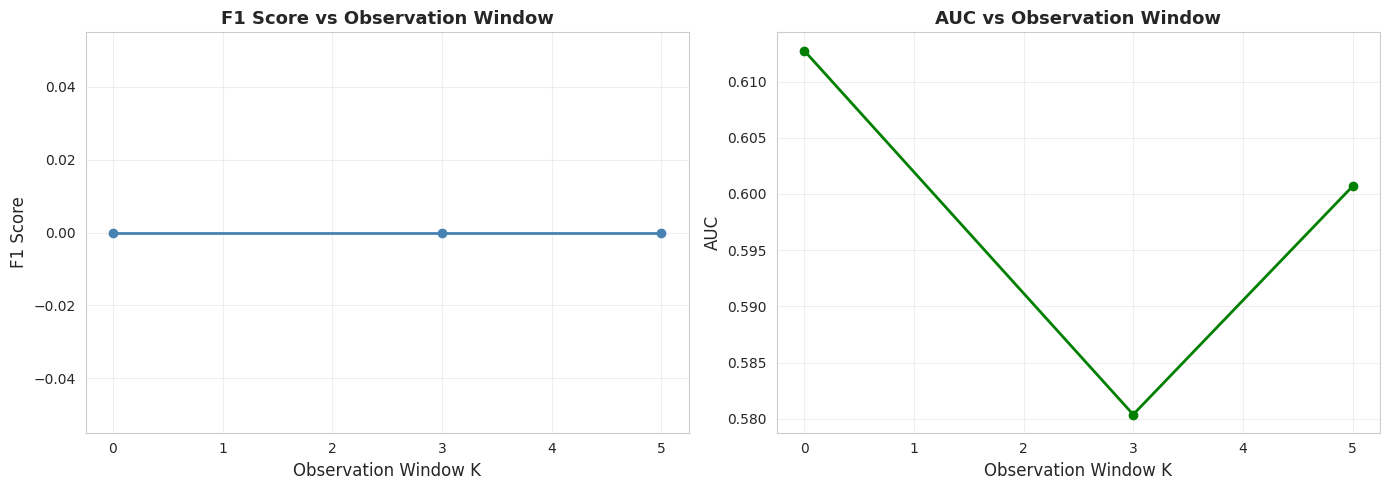

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
f1_scores = [results[K]['test']['f1'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', linewidth=2, color='steelblue')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
auc_scores = [results[K]['test']['auc'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', linewidth=2, color='green')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [ ]:
import os

os.makedirs('../../results', exist_ok=True)
os.makedirs('../../models', exist_ok=True)

comparison_df.to_csv('../../results/static_gcn_results.csv', index=False)
print("Results saved to ../../results/static_gcn_results.csv")

for K, model in models.items():
    torch.save(model.state_dict(), f'../../models/static_gcn_k{K}.pt')
print(f"Models saved to ../../models/static_gcn_k*.pt")